In [279]:
# import libraries

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [280]:
# load crime data from data folder

df = pd.read_csv('../data/raw/crime.csv')
df.head()

,state,murder.rate,poverty,high.school,college,single.parent,unemployed,metropolitan,region
0,Alabama,7.4,14.7,77.5,20.4,26.0,4.6,70.2,South
1,Alaska,4.3,8.4,90.4,28.1,23.2,6.6,41.6,West
2,Arizona,7.0,13.5,85.1,24.6,23.5,3.9,87.9,West
3,Arkansas,6.3,15.8,81.7,18.4,24.7,4.4,49.0,South
4,California,6.1,14.0,81.2,27.5,21.8,4.9,96.7,West


In [281]:
# just so we can see the unique variables in the "regions" column

unique_regions = df['region'].unique()
unique_regions

array(['South', 'West', 'Northeast', 'North Central'], dtype=object)

In [282]:
# Create dummy variables for 'region', so we can model & complete ANOVA

df_encoded = pd.get_dummies(df, columns=['region'], drop_first=False)

In [283]:
for col in ['region_North Central', 'region_Northeast', 'region_South', 'region_West']:
    df_encoded[col] = df_encoded[col].astype(int)

In [284]:
# check to make sure it worked

df_encoded.head()

,state,murder.rate,poverty,high.school,college,single.parent,unemployed,metropolitan,region_North Central,region_Northeast,region_South,region_West
0,Alabama,7.4,14.7,77.5,20.4,26.0,4.6,70.2,0,0,1,0
1,Alaska,4.3,8.4,90.4,28.1,23.2,6.6,41.6,0,0,0,1
2,Arizona,7.0,13.5,85.1,24.6,23.5,3.9,87.9,0,0,0,1
3,Arkansas,6.3,15.8,81.7,18.4,24.7,4.4,49.0,0,0,1,0
4,California,6.1,14.0,81.2,27.5,21.8,4.9,96.7,0,0,0,1


In [285]:
# declare variables (drop murder rate and state from X)

X = df_encoded.drop(columns=['murder.rate', 'state'])
y = df_encoded['murder.rate']

In [286]:
#Add random seed

# run whole model
X_const = sm.add_constant(X)
model = sm.OLS(y, X_const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            murder.rate   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     9.851
Date:                Thu, 23 Oct 2025   Prob (F-statistic):           9.29e-08
Time:                        11:30:00   Log-Likelihood:                -87.253
No. Observations:                  50   AIC:                             194.5
Df Residuals:                      40   BIC:                             213.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.2190 

In [287]:
# Rename columns with dots to underscores
df_encoded = df_encoded.rename(columns=lambda x: x.replace('.', '_'))
df_encoded = df_encoded.rename(columns=lambda x: x.replace(' ', '_'))

#Look for this  murder_rate ~., data=df_encoded
# Now your formula should be:
full_model = smf.ols(
    'murder_rate ~ poverty + high_school + college + single_parent + unemployed + metropolitan + region_Northeast + region_South + region_West + region_North_Central',
    data=df_encoded
).fit()
print(full_model.summary())

                            OLS Regression Results                            
Dep. Variable:            murder_rate   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     9.851
Date:                Thu, 23 Oct 2025   Prob (F-statistic):           9.29e-08
Time:                        11:30:00   Log-Likelihood:                -87.253
No. Observations:                  50   AIC:                             194.5
Df Residuals:                      40   BIC:                             213.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.2190 

In [288]:
# get rid of the not statistically significant variable if you model fit is adequete (four assumptions )

X_reduced = X[['single.parent']]
X_reduced_const = sm.add_constant(X_reduced)

model_reduced = sm.OLS(y, X_reduced_const).fit()
print(model_reduced.summary())

                            OLS Regression Results                            
Dep. Variable:            murder.rate   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     40.69
Date:                Thu, 23 Oct 2025   Prob (F-statistic):           6.61e-08
Time:                        11:30:00   Log-Likelihood:                -101.11
No. Observations:                  50   AIC:                             206.2
Df Residuals:                      48   BIC:                             210.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -8.2477      2.032     -4.059

In [289]:
# First off, single parent is the only statistically significant variable remaining. I would assume most of the others (except for region dummies) are
# correlated with single parent households. As for the region dummies, it seems that region does not have a statistically significant effect on murder
# rate when controlling for the other variables in the model.

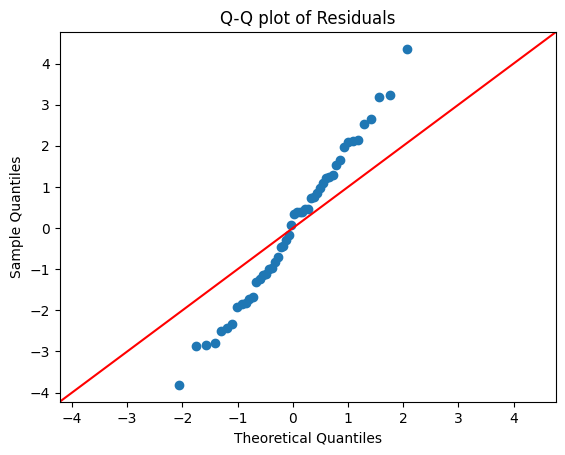

In [290]:
# Q-Q plot of residuals
sm.qqplot(model_reduced.resid, line ='45')
plt.title("Q-Q plot of Residuals")  
plt.show()

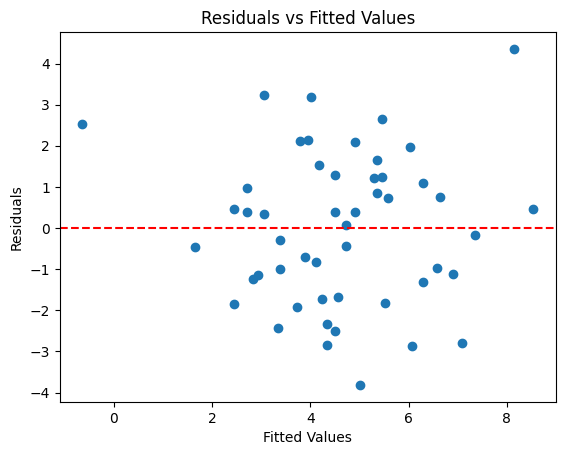

In [291]:
# that looks decently close

# Plot the residuals
plt.scatter(model_reduced.fittedvalues, model_reduced.resid)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

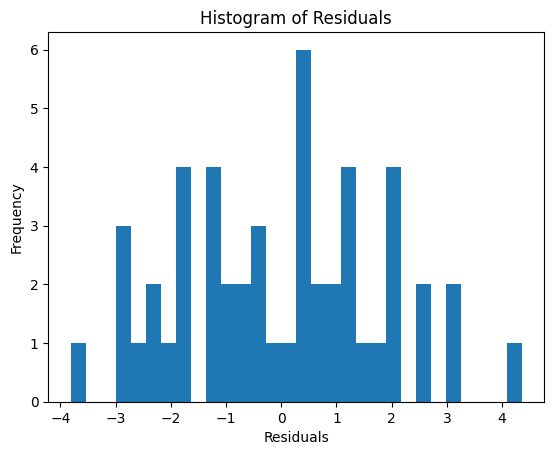

In [292]:
# the residuals seem to be randomly scattered around 0, which is a good sign

# Plot the histogram of residuals
plt.hist(model_reduced.resid, bins=30)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

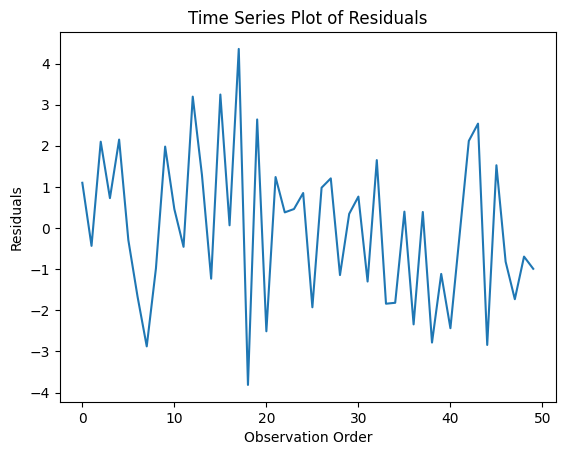

In [293]:
# we only have 50 data points, so it's hard to draw strong conclusions about normality. However, it looks decently normal!

# time series plot of residuals
plt.plot(model_reduced.resid)
plt.title('Time Series Plot of Residuals')
plt.xlabel('Observation Order')
plt.ylabel('Residuals')
plt.show()

In [294]:
# Since no transofrmations were complete, there are no transformation impacts on the model or assumptions.

In [295]:
# ANOVA

In [296]:
np.random.seed(214)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=214)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(40, 10) (10, 10) (40,) (10,)


In [297]:
# Train a linear regression model
sk_model = LinearRegression()
sk_model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [298]:
# use the model to make predictions
y_train_sk = sk_model.predict(X_train)
r2_sk_train = sk_model.score(X_train, y_train)
print("R² on test set (scikit-learn model):", r2_sk_train)

#HUH??

R² on test set (scikit-learn model): 0.7162247626538154


In [299]:
# use the model to make predictions
y_pred_sk = sk_model.predict(X_test)
r2_sk_test = sk_model.score(X_test, y_test)
print("R² on test set (scikit-learn model):", r2_sk_test)

R² on test set (scikit-learn model): 0.2725910727718007


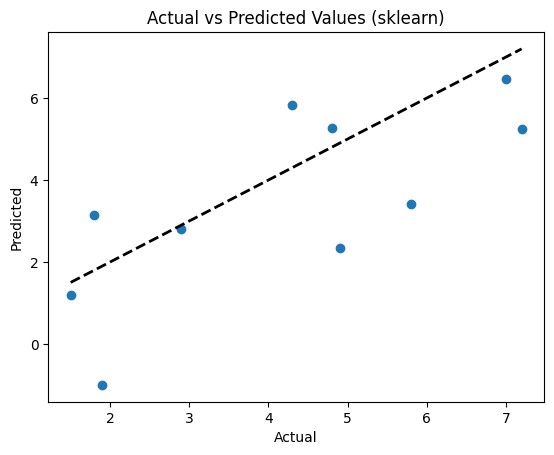

In [300]:
# create a scatter plot of actual vs predicted values
plt.scatter(y_test, y_pred_sk)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values (sklearn)')
plt.show()

In [301]:
numeric_features = ['poverty', 'high_school', 'college', 'single_parent', 'unemployed', 'metropolitan',
                    'region_North_Central', 'region_Northeast', 'region_South', 'region_West']

In [302]:
#Add random seed for reproducibility
np.random.seed(1122)

#Cross validation with KFold
kf=KFold(n_splits=5, shuffle=True, random_state=1242)

#Create a pipeline using sklearn pipeline to impute missing values
pipe = Pipeline([('Imputer', SimpleImputer(strategy = 'mean')), ('Scaler', StandardScaler()), ('LR', LinearRegression())])

#Fit the pipeline using cross validation
scores = cross_val_score(pipe, X_train, y_train, cv=kf)

In [303]:
print("R² scores for each fold:", scores)
print("Average R² score:", np.mean(scores))

R² scores for each fold: [0.62183797 0.35904552 0.25811666 0.09944818 0.59804398]
Average R² score: 0.38729846247723204


In [304]:
# calculate r^2 on training and testing sets for reduced model

In [305]:
# discuss the strengths and limitations of each approach in the context of this analysis

In [306]:
# Making recommendations for further research or analysis that could help refine the understanding of the factors influencing murder rates.

In [307]:
# Discussion

# What do I believe I did well on this assignment?
    # We understood what we needed to do, and we did well at researching the parts we did not understand. 

# What was the most challenging part of this assignment?
    # Finding the R^2 value for the statsmodels model. Also, validating our work was a little difficult.

# What would have made this assignment a better experience?
    # It would have been convenient to have resources for each steps to research to make sure we are doing the process correctly. Also, it might be helpful to have the notes from class available on the canvas.

# What do I need help with?
    # Knowing how to calculate the R^2 value in all the different models. Knowing how to look for anomalies/how to interpret the code. 

In [308]:
# r^2 for both
# low r^2 values...?
# separate into two datasets for each model? - categorical variables
# no transformations